# Machine Learning in Python - Project 1

Due Friday, April 15th by 5 pm UK local time.

*include contributors names here*

## 0. Setup

In [84]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

import os
#from google.colab import drive

In [2]:
# Load data
#drive.mount('/content/drive') # give permission
#os.chdir('drive/My Drive/Colab Notebooks/ML for python/project 2')
#os.chdir('drive/My Drive/Colab Notebooks/mlp/project-2')
d = pd.read_csv("hotel.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [3]:
df = d.copy()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### 2.1 Data Cleaning

Before feature selection and data preprocessing, we explored deeply into the raw data first, and found some improper data based on the realistic logic. Specifically, we deleted some data according to the following criteria:

  - The variable `repeated_guest` marked as 0 should have no previous booking.
  
  - Average daily rate `adr` should have a reasonable value (non-negative and no more than 1000).
  
  - The number of car parking spaces required should be no more than the number of adults.
  
Moreover, missing values of categorical variables, i.e., `country`, `distribution_channel`, are deleted, as they occupy small proportions.

As for the numerical variable `children` with a small amount of missing values, it was imputed by its mean value.

In [4]:
# drop observations with no previous booking but considered as repeated guest
drop_idx_1 = df.loc[(df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] > 0)].index
df.drop(index = drop_idx_1, inplace = True)

In [5]:
# drop observations with improper values
drop_idx_2 = df.loc[(df['adr'] < 0) | (df['adr'] > 1000)].index
df.drop(index = drop_idx_2, inplace = True)

In [6]:
# drop observations with required car parking spaces over the number of adults
drop_idx_3 = df.loc[df['required_car_parking_spaces'] > df['adults']].index
df.drop(index = drop_idx_3, inplace = True)

In [7]:
# drop observations where country is missing
drop_idx_4 = df.loc[df['country'].isna() == True].index
df.drop(index = drop_idx_4, inplace = True)

In [8]:
# drop observations with undefined market segment
drop_idx_5 = df.loc[df['distribution_channel'] == 'Undefined'].index
df.drop(index = drop_idx_5, inplace = True)

In [9]:
# impute missing values in children by its mean
df['children'][df['children'].isna()] = round(df['children'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118318 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118318 non-null  int64  
 1   hotel                           118318 non-null  object 
 2   lead_time                       118318 non-null  int64  
 3   arrival_date_year               118318 non-null  int64  
 4   arrival_date_month              118318 non-null  object 
 5   arrival_date_week_number        118318 non-null  int64  
 6   arrival_date_day_of_month       118318 non-null  int64  
 7   stays_in_weekend_nights         118318 non-null  int64  
 8   stays_in_week_nights            118318 non-null  int64  
 9   adults                          118318 non-null  int64  
 10  children                        118318 non-null  float64
 11  babies                          118318 non-null  int64  
 12  meal            

<ipython-input-9-be0045c869a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['children'][df['children'].isna()] = round(df['children'].mean())


In [10]:
# convert hotel to binary - city : 1, resort : 0
df['hotel_class'] = df['hotel'].apply(lambda x:int(x=='City Hotel'))
# cancellation proportion for each class
print(df.groupby(['hotel_class'])['is_canceled'].sum()/df.groupby(['hotel_class'])['is_canceled'].count())
print(df['hotel_class'].sum()/df['hotel_class'].count())

hotel_class
0    0.282168
1    0.417870
Name: is_canceled, dtype: float64
0.6686894639868828


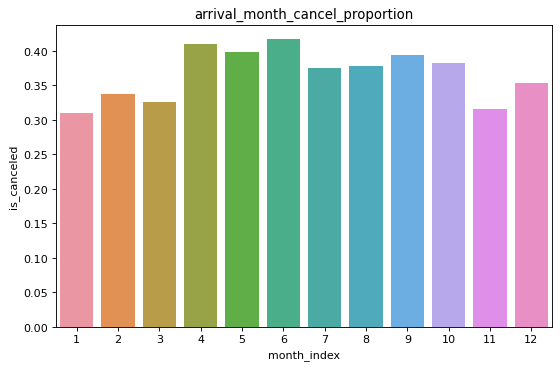

In [11]:
# histogram for cancellation proportion of each month
arrival_month_cancel_proportion = df.groupby(['arrival_date_month'])['is_canceled'].sum('is_canceled')/df.groupby(['arrival_date_month'])['is_canceled'].count()
month_df = arrival_month_cancel_proportion.to_frame().reset_index()
month_df['month_index'] = [4,8,12,2,1,7,6,3,5,11,10,9]
sns.barplot(x = month_df['month_index'], y = month_df['is_canceled']).set(title='arrival_month_cancel_proportion')
plt.show()

In [64]:
# convert month to binary - 4-10 : 1, others : 0
df['month_class'] = df['arrival_date_month'].apply(lambda x:int(x in ['April', 'May', 'June', 'July', 'August', 'September', 'October']))
# cancellation proportion for each class
print(df.groupby(['month_class'])['is_canceled'].sum()/df.groupby(['month_class'])['is_canceled'].count())
print(df['month_class'].sum()/df['month_class'].count())

month_class
0    0.328893
1    0.403404
Name: is_canceled, dtype: float64
0.6827336891031158


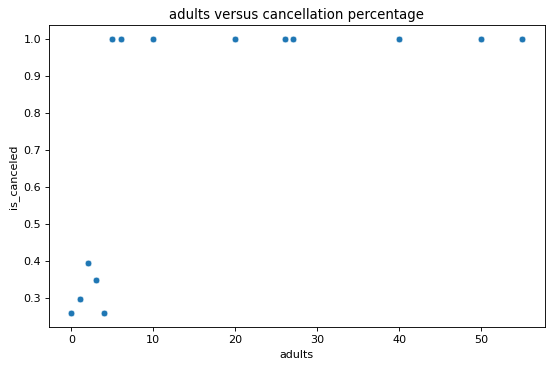

In [29]:
adults_cancel_prop = df.groupby(['adults'])['is_canceled'].sum()/df.groupby(['adults'])['is_canceled'].count()
# adults
adults_cancel_prop_df = adults_cancel_prop.to_frame().reset_index()
sns.scatterplot(x=adults_cancel_prop_df['adults'], y=adults_cancel_prop_df['is_canceled']).set(title='adults versus cancellation percentage')
plt.show()

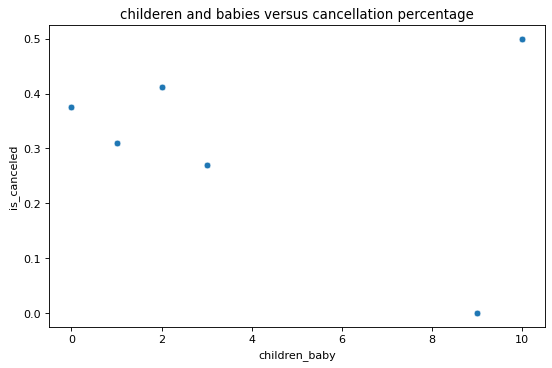

In [30]:
# children and baby
df['children_baby'] = df['children'] + df['babies']

chil_cancel_prop = df.groupby(['children_baby'])['is_canceled'].sum()/df.groupby(['children_baby'])['is_canceled'].count()

chil_cancel_prop_df = chil_cancel_prop.to_frame().reset_index()
sns.scatterplot(x=chil_cancel_prop_df['children_baby'], y=chil_cancel_prop_df['is_canceled']).set(title='childeren and babies versus cancellation percentage')
plt.show()

In [12]:
# convert country to binary - PRT : 1, non-PRT : 0
df['country_prt'] = df['country'].apply(lambda x:int(x=='PRT'))
# cancellation proportion for each class
print(df.groupby(['country_prt'])['is_canceled'].sum()/df.groupby(['country_prt'])['is_canceled'].count())
print(df['country_prt'].sum()/df['country_prt'].count())

country_prt
0    0.237155
1    0.570577
Name: is_canceled, dtype: float64
0.4071569837218344


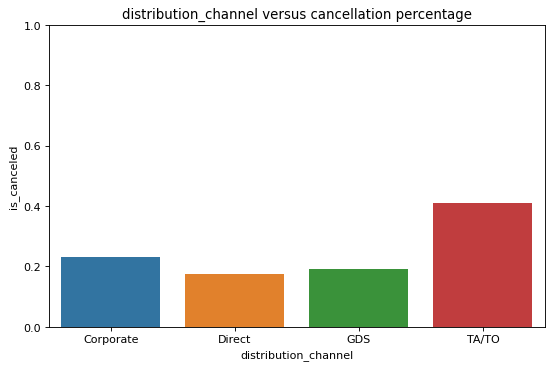

distribution_channel
Corporate    0.053094
Direct       0.121224
GDS          0.001623
TA/TO        0.824059
Name: distribution_channel, dtype: float64

In [13]:
# histograms for distribution channel
dis_type = df.groupby(['distribution_channel'])['is_canceled'].sum()/df.groupby(['distribution_channel'])['is_canceled'].count()
dis_type_df = dis_type.to_frame().reset_index()
sns.barplot(x=dis_type_df['distribution_channel'], y=dis_type_df['is_canceled']).set(title='distribution_channel versus cancellation percentage', ylim=(0,1))
plt.show()
df.groupby(['distribution_channel'])['distribution_channel'].count()/df['distribution_channel'].count()

In [14]:
# convert distribution channel to binary - TA/TO : 1, non-TA/TO : 0
df['distribution_channel_class'] = df['distribution_channel'].apply(lambda x:int(x=='TA/TO'))
# cancellation proportion for each class
print(df.groupby(['distribution_channel_class'])['is_canceled'].sum()/df.groupby(['distribution_channel_class'])['is_canceled'].count())
print(df['distribution_channel_class'].sum()/df['distribution_channel_class'].count())

distribution_channel_class
0    0.192919
1    0.411339
Name: is_canceled, dtype: float64
0.8240588921381362


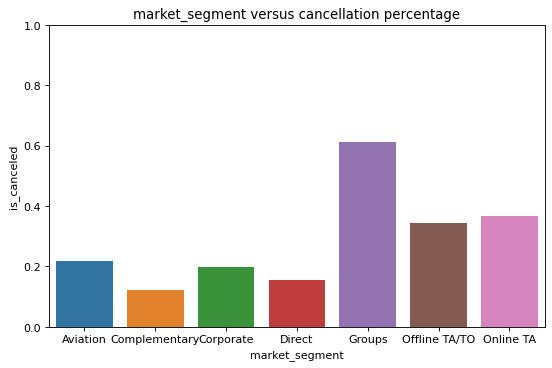

market_segment
Aviation         0.002003
Complementary    0.006136
Corporate        0.041524
Direct           0.104084
Groups           0.166898
Offline TA/TO    0.203562
Online TA        0.475794
Name: market_segment, dtype: float64

In [15]:
# histograms for market segment
mar_type = df.groupby(['market_segment'])['is_canceled'].sum()/df.groupby(['market_segment'])['is_canceled'].count()
mar_type_df = mar_type.to_frame().reset_index()
sns.barplot(x=mar_type_df['market_segment'], y=mar_type_df['is_canceled']).set(title='market_segment versus cancellation percentage', ylim=(0,1))
plt.show()
df.groupby(['market_segment'])['market_segment'].count()/df['market_segment'].count()

In [16]:
# cancellation proportion for each class
print(df.groupby(['is_repeated_guest'])['is_canceled'].sum()/df.groupby(['is_repeated_guest'])['is_canceled'].count())
print(df['is_repeated_guest'].sum()/df['is_repeated_guest'].count())

is_repeated_guest
0    0.380468
1    0.145225
Name: is_canceled, dtype: float64
0.03212528947412904


In [17]:
# convert previous_cancellations_class to binary - non-zero : 1, zero : 0
df['previous_cancellations_class'] = df['previous_cancellations'].apply(lambda x:int(x!=0))
# cancellation proportion for each class
print(df.groupby(['previous_cancellations_class'])['is_canceled'].sum()/df.groupby(['previous_cancellations_class'])['is_canceled'].count())
print(df['previous_cancellations_class'].sum()/df['previous_cancellations_class'].count())

previous_cancellations_class
0    0.341461
1    0.926427
Name: is_canceled, dtype: float64
0.05376189590763874


In [18]:
# create a new binary column for reserved and assigned - matching : 1, non-matching : 0
df['reserved_equal_assigned'] = np.where((df['reserved_room_type'] == df['assigned_room_type']), 1, 0)
# cancellation proportion for each class
print(df.groupby(['reserved_equal_assigned'])['is_canceled'].sum()/df.groupby(['reserved_equal_assigned'])['is_canceled'].count())
print(df['reserved_equal_assigned'].sum()/df['reserved_equal_assigned'].count())

reserved_equal_assigned
0    0.054496
1    0.417305
Name: is_canceled, dtype: float64
0.877634848459237


In [19]:
# convert booking_changes to binary - changed : 1, non-changed : 0
df['booking_changes_class'] = df['booking_changes'].apply(lambda x:int(x!=0))
# cancellation proportion for each class
print(df.groupby(['booking_changes_class'])['is_canceled'].sum()/df.groupby(['booking_changes_class'])['is_canceled'].count())
print(df['booking_changes_class'].sum()/df['booking_changes_class'].count())

booking_changes_class
0    0.410986
1    0.158290
Name: is_canceled, dtype: float64
0.1506786794908636


[Text(0.5, 1.0, 'deposit_type versus cancellation percentage'), (0.0, 1.0)]

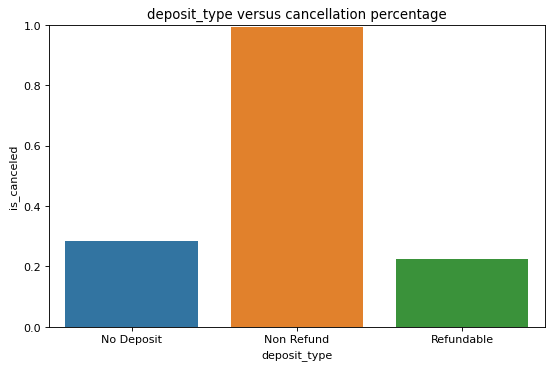

In [20]:
# histogram for cancellation proportions for each deposit type
depos = df.groupby(['deposit_type'])['is_canceled'].sum()/df.groupby(['deposit_type'])['is_canceled'].count()
depos_df = depos.to_frame().reset_index()
sns.barplot(x = depos_df['deposit_type'], y=depos_df['is_canceled']).set(title='deposit_type versus cancellation percentage', ylim=(0,1))

In [41]:
idxxxx = np.where(df['deposit_type'] == 'Non Refund')
idxxxx[0][0:5]

array([2132, 2133, 2134, 2135, 2140], dtype=int64)

In [46]:
# one hot encoding for deposit type
onehot = OneHotEncoder(handle_unknown='ignore')
dep_encoded = onehot.fit_transform(np.array(df['deposit_type']).reshape(-1, 1))
dep_encoded_df = pd.DataFrame(dep_encoded.toarray(), columns = ['No_Deposit', 'Non_Refund', 'Refundable'])
df = pd.merge(df, dep_encoded_df, left_index = True, right_index = True)

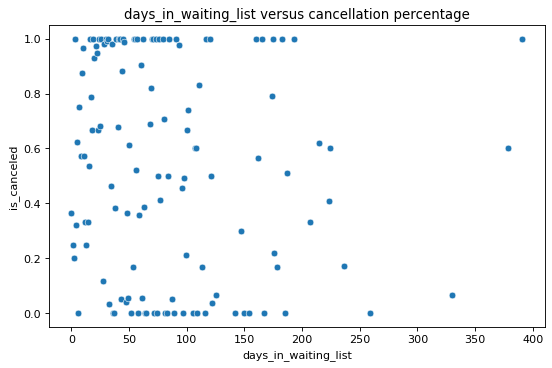

have_days_in_wl
0    0.364364
1    0.639956
Name: is_canceled, dtype: float64

In [21]:
# scatter plot for cancellation proportion over day_in_waiting_list 
days_wl = df.groupby(['days_in_waiting_list'])['is_canceled'].sum()/df.groupby(['days_in_waiting_list'])['is_canceled'].count()
days_wl_df = days_wl.to_frame().reset_index()
sns.scatterplot(x=days_wl_df['days_in_waiting_list'], y=days_wl_df['is_canceled']).set(title='days_in_waiting_list versus cancellation percentage')
plt.show()
# convert this column to binary - wait : 1, non-wait : 0
df['have_days_in_wl'] = np.where((df['days_in_waiting_list'] != 0), 1, 0)
# cancellation proportion for each class
df.groupby(['have_days_in_wl'])['is_canceled'].sum()/df.groupby(['have_days_in_wl'])['is_canceled'].count()

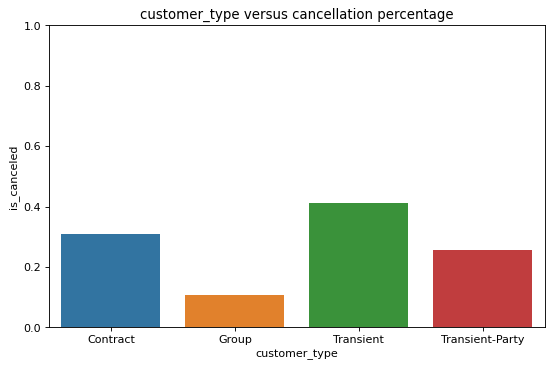

customer_type
Contract           0.034433
Group              0.004429
Transient          0.750148
Transient-Party    0.210991
Name: customer_type, dtype: float64

In [22]:
# histograms for cancellation proportion for each customer type
cust_type = df.groupby(['customer_type'])['is_canceled'].sum()/df.groupby(['customer_type'])['is_canceled'].count()
cust_type_df = cust_type.to_frame().reset_index()
sns.barplot(x=cust_type_df['customer_type'], y=cust_type_df['is_canceled']).set(title='customer_type versus cancellation percentage', ylim=(0,1))
plt.show()
df.groupby(['customer_type'])['customer_type'].count()/df['customer_type'].count()

In [56]:
idxxxx = np.where(df['customer_type'] == 'Transient')
idxxxx[0][0:5]

array([0, 1, 2, 3, 4], dtype=int64)

In [58]:
# one hot encoding for customer type
onehot = OneHotEncoder(handle_unknown='ignore')
cus_encoded = onehot.fit_transform(np.array(df['customer_type']).reshape(-1, 1))
cus_encoded_df = pd.DataFrame(cus_encoded.toarray(), columns = ['Contract', 'Group', 'Transient', 'Transient-Party'])
df = pd.merge(df, cus_encoded_df, left_index = True, right_index = True)

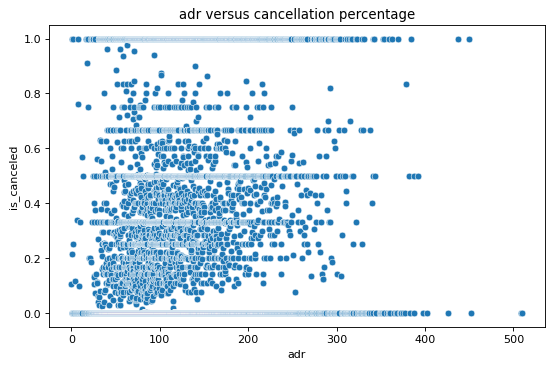

In [23]:
# scatter plot for cancellation proportion over adr
adr_temp = df.groupby(['adr'])['is_canceled'].sum()/df.groupby(['adr'])['is_canceled'].count()
adr_df = adr_temp.to_frame().reset_index()
sns.scatterplot(x=adr_df['adr'], y=adr_df['is_canceled']).set(title='adr versus cancellation percentage')
plt.show()

In [24]:
# covert required_car_parking_spaces to binary - required : 1, non-required : 0
df['required_car_parking_spaces_class'] = df['required_car_parking_spaces'].apply(lambda x:int(x!=0))
# cancellation proportion for each class
print(df.groupby('required_car_parking_spaces_class')['is_canceled'].sum()/df.groupby(['required_car_parking_spaces_class'])['is_canceled'].count())
print(df['required_car_parking_spaces_class'].sum()/df['required_car_parking_spaces_class'].count())

required_car_parking_spaces_class
0    0.39697
1    0.00000
Name: is_canceled, dtype: float64
0.060607853411991416


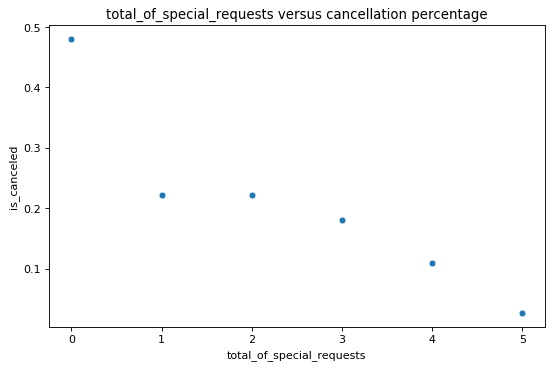

In [25]:
# scatter plot for cancellation proportion over number of special requests
special_req = df.groupby('total_of_special_requests')['is_canceled'].sum()/df.groupby(['total_of_special_requests'])['is_canceled'].count()
special_req = special_req.to_frame().reset_index()
sns.scatterplot(x=special_req['total_of_special_requests'], y=special_req['is_canceled']).set(title='total_of_special_requests versus cancellation percentage')
plt.show()
# obvious negative correlation

In [65]:
# coorelations matrix
df.corr()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,required_car_parking_spaces_class,children_baby,No_Deposit,Non_Refund,Refundable,Contract,Group,Transient,Transient-Party,month_class
is_canceled,1.000000,0.302014,0.034337,0.013073,-0.003738,-0.002997,0.023442,0.059896,0.008077,-0.033271,...,-0.199410,-0.000128,-0.356151,0.358809,-0.008494,-0.000294,-0.031994,0.087912,-0.087953,0.071453
lead_time,0.302014,1.000000,0.033543,0.125083,-0.000249,0.082665,0.164815,0.116490,-0.040639,-0.021195,...,-0.117828,-0.044287,-0.165523,0.165545,0.006812,-0.002551,-0.018650,0.005078,-0.001207,0.255962
arrival_date_year,0.034337,0.033543,1.000000,-0.557880,-0.004127,0.021597,0.032600,0.025538,0.050670,-0.013320,...,-0.012920,0.045749,0.044743,-0.045005,0.000428,-0.068362,-0.028865,0.158113,-0.132479,-0.059290
arrival_date_week_number,0.013073,0.125083,-0.557880,1.000000,0.064778,0.017300,0.014554,0.023822,0.003750,0.010016,...,0.003600,0.006007,-0.013951,0.016271,-0.019989,0.057279,0.014693,-0.062873,0.038677,0.208559
arrival_date_day_of_month,-0.003738,-0.000249,-0.004127,0.064778,1.000000,-0.017317,-0.028128,0.001033,0.015179,-0.000213,...,0.009142,0.014605,0.001141,-0.003985,0.025169,0.003053,-0.002700,0.001996,-0.003046,-0.000287
stays_in_weekend_nights,-0.002997,0.082665,0.021597,0.017300,-0.017317,1.000000,0.496069,0.090426,0.046682,0.018328,...,-0.019709,0.049439,0.053912,-0.053994,-0.001554,0.021552,0.001235,0.010556,-0.021057,0.062098
stays_in_week_nights,0.023442,0.164815,0.032600,0.014554,-0.028128,0.496069,1.000000,0.091629,0.046259,0.020507,...,-0.026749,0.049549,0.051753,-0.052731,0.006487,0.034124,-0.004734,0.013041,-0.028352,0.049756
adults,0.059896,0.116490,0.025538,0.023822,0.001033,0.090426,0.091629,1.000000,0.029798,0.017883,...,0.018968,0.033031,-0.004313,0.004303,0.000271,0.005767,-0.001761,0.006578,-0.009277,0.099427
children,0.008077,-0.040639,0.050670,0.003750,0.015179,0.046682,0.046259,0.029798,1.000000,0.023945,...,0.058910,0.971223,0.029699,-0.030077,0.002098,0.006225,-0.002597,0.014838,-0.018112,0.039181
babies,-0.033271,-0.021195,-0.013320,0.010016,-0.000213,0.018328,0.020507,0.017883,0.023945,1.000000,...,0.038778,0.261360,0.018064,-0.018879,0.006462,0.012465,0.006459,-0.002402,-0.004086,0.001972


### 2.x Subset for future modelling

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116180 entries, 0 to 117248
Data columns (total 47 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   is_canceled                        116180 non-null  int64  
 1   hotel                              116180 non-null  object 
 2   lead_time                          116180 non-null  int64  
 3   arrival_date_year                  116180 non-null  int64  
 4   arrival_date_month                 116180 non-null  object 
 5   arrival_date_week_number           116180 non-null  int64  
 6   arrival_date_day_of_month          116180 non-null  int64  
 7   stays_in_weekend_nights            116180 non-null  int64  
 8   stays_in_week_nights               116180 non-null  int64  
 9   adults                             116180 non-null  int64  
 10  children                           116180 non-null  float64
 11  babies                             1161

In [67]:
column_names = ['is_canceled', 'lead_time', 'month_class', 'adults', 'country_prt', 'distribution_channel_class', 
                'is_repeated_guest', 'previous_cancellations_class', 'reserved_equal_assigned', 'booking_changes_class',
                'No_Deposit', 'Non_Refund', 'Refundable', 'have_days_in_wl', 'Contract', 'Group', 'Transient', 'Transient-Party',
                'required_car_parking_spaces_class', 'total_of_special_requests']
len(column_names)

20

In [68]:
df_final = df.loc[:, column_names]
df_final

,is_canceled,lead_time,month_class,adults,country_prt,distribution_channel_class,is_repeated_guest,previous_cancellations_class,reserved_equal_assigned,booking_changes_class,No_Deposit,Non_Refund,Refundable,have_days_in_wl,Contract,Group,Transient,Transient-Party,required_car_parking_spaces_class,total_of_special_requests
0,0,342,1,2,1,0,0,0,1,1,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
1,0,737,1,2,1,0,0,0,1,1,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
2,0,7,1,1,0,0,0,0,0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
3,0,13,1,1,0,0,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0
4,0,14,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117244,0,468,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,1
117245,0,244,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,2
117246,0,244,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,2
117247,0,90,1,2,0,1,0,0,1,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,0


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

In [72]:
# drop one attribute of one-hot-encoded variables
df_final_ = df_final.copy()
df_final_.drop(columns=['No_Deposit', 'Transient'])

# split data into 3 parts
train_valid_df, test_df = train_test_split(df_final_, test_size = 0.2, random_state = 42, shuffle = True)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2, random_state = 42, shuffle = True)

In [76]:
output = 'is_canceled'
y_train = train_df.loc[:,output]
X_train = train_df.drop(output, axis = 1)

y_valid = valid_df.loc[:,output]
X_valid = valid_df.drop(output, axis = 1)

y_test = test_df.loc[:,output]
X_test = test_df.drop(output, axis = 1)

### 3.x Logistic Regression

In [75]:
lr = LogisticRegression(random_state = 42, max_iter = 1000).fit(X_train, y_train)

In [82]:
pred_prob_valid = lr.predict_proba(X_valid)
y_valid_pred = lr.predict(X_valid)

In [85]:
print('The mean squared error is {}.'.format(mean_squared_error(y_valid, y_valid_pred)))
print('The accuracy score is {}.'.format(accuracy_score(y_valid, y_valid_pred)))
print('The ROC-AUC score is {}.'.format(roc_auc_score(y_valid, pred_prob_valid[:,1])))

The mean squared error is 0.19210285652805423.
The accuracy score is 0.8078971434719457.
The ROC-AUC score is 0.8761180359612691.


## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*